# Cortex Capstone Code

## Table of Contents
1. Data Cleaning
2. Readability Analysis
3. Binning
4. Double Lasso Regression

In [58]:
#Import statements
import json
import csv
import pandas as pd
import numpy as np
import re
import gc
import textstat
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#Universal Variables
imagetags = set() #All image tags found by the API
hashtags = set() #All hashtags used by all the photos
imageobjects = set() #All the objects found by the API
imagecolors = set() #All the top 3 colors found by the API
fieldnames = ['PageName', 'PostID', 'PostTime', 'Height', 'Width', 'Followers', 'Comments', 'Likes']
#Used to see all column names in output display
pd.set_option('display.max_columns', 500)

## Data Cleaning
This is how we made our data set from the given JSON.  We have included the full dataset as well since this code takes around 8 hours to run.

In [2]:
def Column_Headers(imagetags, hashtags, imageobjects, imagecolors):
    file = 'cortex-travel-industry-metadata-updated.json' #JSON file we want to load in, assumed to be in the same folder
    with open(file, mode = 'r', encoding = 'utf-8') as f: 
        data = json.loads(f.read(), encoding = 'utf-8') #Load the data file
    #Get all the column header names from the data
    for photo in data: #Loop through every photo in the data set
        md = photo['metadata'] #The photo's metadata
        tags = md.get('imageTags', '') #The photo's image tags by the API
        ht = md.get('hashtags', '') #The photo's hash tags by the user
        objects = md.get('imageObjects','') #Objects in the photo found by the API
        colors = md.get('imageColors','') #The 3 main colors in the photo found by the API
        #Add the info found in the photo into the sets
        for tag in tags:
            imagetags.add(tag['value'])
        for tag in ht:
            hashtags.add(tag)
        for obj in objects:
            imageobjects.add(obj['name'])
        for color in colors:
            imagecolors.add(color['value'])
    return data

In [3]:
def Image_Tag_Data(fieldnames, data, imagetags):
    fn = fieldnames.copy() #Copy the common field names
    length = 8+len(imagetags) #Find the length of the image tag data frame
    #Add each tag into the fieldnames, make sure it is labelled as an image tag
    for tag in imagetags:
        fn.append(tag+'_tag')
    DF = pd.DataFrame() #The soon to be complete data set
    for photo in data: #Get the data out with the associated column name
        photodata = list(['0']*length) #blank row of data
        md = photo['metadata'] #The photo's metadata
        tags = md.get('imageTags','') #The photo's image tags by the API
        #Set the variables
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = photo['nFollowers']
        photodata[6] = photo['nComments']
        photodata[7] = photo['nLikes']
        i = 8
        for tag1 in imagetags:
            for tag2 in tags:
                if tag1 == tag2['value']:
                    photodata[i] = 1 #tag2['confidence'] We decided to use binary data instead of the confidence score
                    break
            i = i+1
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn) #turn our list into a dataframe
        DF = DF.append(df_temp, ignore_index = True) #Combine this temp data frame with our complete data set
    #Setting the type on the variables in the data frame
    DF1 = DF.iloc[:,0:8]
    DF2 = DF.iloc[:,8:]
    DF2 = DF2.astype(float)
    DF2 = DF2.round(decimals=0)
    DF2 = DF2.astype(int)
    sum1 = DF2.sum(axis=0)
    badCols = list()
    #Find the index of all the columns whose tag shows up less than 10 times
    for index in range(len(sum1)):
        if sum1[index]  < 10:
            badCols.append(index)
    #Remove the bad tags
    DF2 = DF2.drop(DF2.columns[badCols], axis=1)
    DF = pd.concat([DF1, DF2],axis=1)
    return DF

In [4]:
def Hashtag_Data(fieldnames, data, hashtags):
    #These next few functions all are copy and paste versions of the one above but for the other variables
    fn = fieldnames.copy()
    length = 8+len(hashtags)
    for tag in hashtags:
        fn.append(tag+'_ht')
    DF = pd.DataFrame()
    for photo in data: #Get the data out with the associated column name
        photodata = list(['0']*length)
        md = photo['metadata'] #The photo's metadata
        ht = md['hashtags']
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = photo['nFollowers']
        photodata[6] = photo['nComments']
        photodata[7] = photo['nLikes']
        i = 8
        for tag1 in hashtags:
            for tag2 in ht:
                if tag1 == tag2:
                    photodata[i] = 1
                    break
            i = i+1
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn)
        DF = DF.append(df_temp, ignore_index = True)
    DF1 = DF.iloc[:,0:8]
    DF2 = DF.iloc[:,8:]
    DF2 = DF2.astype(int)
    sum1 = DF2.sum(axis=0)
    badCols = list()
    for index in range(len(sum1)):
        if sum1[index]  < 10:
            badCols.append(index)
    DF2 = DF2.drop(DF2.columns[badCols], axis=1)
    DF = pd.concat([DF1, DF2],axis=1)
    return DF

In [5]:
def Image_Object_Data(fieldnames, data, imageobjects):    
    fn = fieldnames.copy()
    length = 8+len(imageobjects)
    for objects in imageobjects:
        fn.append(objects+'_obj')
    DF = pd.DataFrame()
    for photo in data: #Get the data out with the associated column name
        photodata = list(['0']*length)
        md = photo['metadata'] #The photo's metadata
        objects = md['imageObjects']
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = photo['nFollowers']
        photodata[6] = photo['nComments']
        photodata[7] = photo['nLikes']
        i = 8
        for object1 in imageobjects:
            for object2 in objects:
                if object1 == object2['name']:
                    photodata[i] = 1 #object2['conf']
                    break
            i = i+1
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn)
        DF = DF.append(df_temp, ignore_index = True)
    str_obj = DF.iloc[:,0:8] #creates dataset of just str data
    int_obj = DF.iloc[:,8:]
    int_obj = int_obj.astype(int) #creates dataset to convert datatypes to int
    sum1 = int_obj.sum(axis=0) #get sums of columns
    badCols = list()
    for index in range(len(sum1)):
        if sum1[index] < 5: #if object occurs less than 5 times, column name will be added to badCols list
            badCols.append(index)
    int_obj = int_obj.drop(int_obj.columns[badCols], axis=1) #names in badCols list will be dropped from original dataset
    DF= pd.concat([str_obj, int_obj], axis=1) #combines str & int datasets
    return DF

In [6]:
def Image_Color_Data(fieldnames, data, imagecolors):
    fn = fieldnames.copy()
    length = 8+len(imagecolors)
    for color in imagecolors:
        fn.append(color)
    DF = pd.DataFrame()
    for photo in data: #Get the data out with the associated column name
        photodata = list(['0']*length)
        md = photo['metadata'] #The photo's metadata
        colors = md['imageColors']
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = photo['nFollowers']
        photodata[6] = photo['nComments']
        photodata[7] = photo['nLikes']
        i = 8
        for color1 in imagecolors:
            for color2 in colors:
                if color1 == color2['value']:
                    photodata[i] = color2['confidence']
                    break
            i = i+1
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn)
        DF = DF.append(df_temp, ignore_index = True)
    DF.columns = map(str.upper, DF.columns) #Capitalize all column names
    #Here we are taking all the top 3 colors found by the API and mapping them to more general colors
    #So instead of having both Maroon and Scarlet in the data set, we would label them both as Red
    #Color Group.csv is a file that lists every hex color as one of 12 colors. It will be included in the 
    #folder with this code
    with open('Color Group.csv', mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    DF=DF.rename(index=str,columns=mydict) #Rename all the columns in the data frame.  Now we could have multiple columns labelled Green
    #create a list of color groups
    color=['Pink','Purple','Red','Orange','Yellow','Green','Cyan','Blue','Brown','White','Grey','Black']
    #change value tpe to float
    for c in color:
        DF[c]=DF[c].astype('float')
    df=DF.transpose().reset_index().rename(columns={'index':'Color'}) #transpose dataset 
    df = df.groupby('Color').sum() #Group same colors together and sum their values together
    DF=df.T #transpose back
    cols = ['PageName', 'PostID', 'PostTime','Height','Width','Followers', 'Comments', 'Likes', 'Pink','Purple','Red','Orange','Yellow','Green','Cyan','Blue','Brown','White','Grey','Black']
    DF = DF.reindex(columns=cols)
    return DF

In [7]:
def sylco(word):  #Syllable counter given only the spelling of a word
    #This is code I pulled from https://eayd.in/?p=232
    #There really are no good syllable counters for the english language based solely on the spelling of the words
    #This code combines the 14 most common syllable counting rules we know to get the best prediction for the number
    #of syllables a word would have
    word = word.lower()

    # exception_add are words that need extra syllables
    # exception_del are words that need less syllables

    exception_add = ['serious','crucial']
    exception_del = ['fortunately','unfortunately', 'facebook']

    co_one = ['cool','coach','coat','coal','count','coin','coarse','coup','coif','cook','coign','coiffe','coof','court']
    co_two = ['coapt','coed','coinci']

    pre_one = ['preach']

    syls = 0 #added syllable number
    disc = 0 #discarded syllable number

    #1) if letters < 3 : return 1
    if len(word) <= 3 :
        syls = 1
        return syls

    #2) if doesn't end with "ted" or "tes" or "ses" or "ied" or "ies", discard "es" and "ed" at the end.
    # if it has only 1 vowel or 1 set of consecutive vowels, discard. (like "speed", "fled" etc.)

    if word[-2:] == "es" or word[-2:] == "ed" :
        doubleAndtripple_1 = len(re.findall(r'[eaoui][eaoui]',word))
        if doubleAndtripple_1 > 1 or len(re.findall(r'[eaoui][^eaoui]',word)) > 1 :
            if word[-3:] == "ted" or word[-3:] == "tes" or word[-3:] == "ses" or word[-3:] == "ied" or word[-3:] == "ies" :
                pass
            else :
                disc+=1

    #3) discard trailing "e", except where ending is "le"  

    le_except = ['whole','mobile','pole','male','female','hale','pale','tale','sale','aisle','whale','while']

    if word[-1:] == "e" :
        if word[-2:] == "le" and word not in le_except :
            pass

        else :
            disc+=1

    #4) check if consecutive vowels exists, triplets or pairs, count them as one.

    doubleAndtripple = len(re.findall(r'[eaoui][eaoui]',word))
    tripple = len(re.findall(r'[eaoui][eaoui][eaoui]',word))
    disc+=doubleAndtripple + tripple

    #5) count remaining vowels in word.
    numVowels = len(re.findall(r'[eaoui]',word))

    #6) add one if starts with "mc"
    if word[:2] == "mc" :
        syls+=1

    #7) add one if ends with "y" but is not surrouned by vowel
    if word[-1:] == "y" and word[-2] not in "aeoui" :
        syls +=1

    #8) add one if "y" is surrounded by non-vowels and is not in the last word.

    for i,j in enumerate(word) :
        if j == "y" :
            if (i != 0) and (i != len(word)-1) :
                if word[i-1] not in "aeoui" and word[i+1] not in "aeoui" :
                    syls+=1

    #9) if starts with "tri-" or "bi-" and is followed by a vowel, add one.

    if word[:3] == "tri" and word[3] in "aeoui" :
        syls+=1

    if word[:2] == "bi" and word[2] in "aeoui" :
        syls+=1

    #10) if ends with "-ian", should be counted as two syllables, except for "-tian" and "-cian"

    if word[-3:] == "ian" : 
    #and (word[-4:] != "cian" or word[-4:] != "tian") :
        if word[-4:] == "cian" or word[-4:] == "tian" :
            pass
        else :
            syls+=1

    #11) if starts with "co-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:2] == "co" and word[2] in 'eaoui' :

        if word[:4] in co_two or word[:5] in co_two or word[:6] in co_two :
            syls+=1
        elif word[:4] in co_one or word[:5] in co_one or word[:6] in co_one :
            pass
        else :
            syls+=1

    #12) if starts with "pre-" and is followed by a vowel, check if exists in the double syllable dictionary, if not, check if in single dictionary and act accordingly.

    if word[:3] == "pre" and word[3] in 'eaoui' :
        if word[:6] in pre_one :
            pass
        else :
            syls+=1

    #13) check for "-n't" and cross match with dictionary to add syllable.

    negative = ["doesn't", "isn't", "shouldn't", "couldn't","wouldn't"]

    if word[-3:] == "n't" :
        if word in negative :
            syls+=1
        else :
            pass   

    #14) Handling the exceptional words.

    if word in exception_del :
        disc+=1

    if word in exception_add :
        syls+=1     

    # calculate the output
    return numVowels - disc + syls

In [8]:
def Readability_Data(fieldnames, data):
    #Similar start to before by making a fieldname list and an empty data frame
    fn = fieldnames.copy()
    length = 9
    fn.append('Flesch RE')
    DF = pd.DataFrame()
    for photo in data: #Get the data out with the associated column name
        text = photo['rawText'].replace('\u2063','') #For each raw caption remove the hidden character that appears whenever you
        #use a period
        text = text.lower() #Make all the words lower case, so that we can better cleanse it
        text = re.sub(r'[^a-z\s#@]','',text) #Remove everything that isn't a letter or a # or @
        words = text.split() #Make a list of all the words
        i = 0
        while i < len(words):
            if words[i][0] == '#' or words[i][0] == '@': #Remove # and @ words. It's really hard to count syllables on these words
                words.pop(i)
                i = i - 1
            i = i + 1
        photodata = list(['0']*length)
        md = photo['metadata'] #The photo's metadata
        syllb = 0.0 #The reading score is a float but everything in the formula is an int, so make syllb a float to get the
                    #Correct answer
        row = np.array([[0,0,0,0,0]])
        for word in words:
            syllb += sylco(word)
        photodata[0] = photo['pageName']
        photodata[1] = photo['extPostId']
        photodata[2] = photo['extCreatedAt']
        photodata[3] = md['imgHeight']
        photodata[4] = md['imgWidth']
        photodata[5] = photo['nFollowers']
        photodata[6] = photo['nComments']
        photodata[7] = photo['nLikes']
        #If there is no caption, place a NULL there instead
        if len(words) == 0:
            photodata[8] = np.nan
        else:
            photodata[8] = 206.835-1.015*len(words)-84.6*(syllb/len(words))
        df_temp = pd.DataFrame(data = np.array(photodata).reshape((1,len(fn))), columns = fn)
        DF = DF.append(df_temp, ignore_index = True)
    DF['Flesch RE'] = DF['Flesch RE'].astype(float)
    return DF

In [17]:
def DateTime_Parts(data): #Creates a bunch of different dummy date times in boolean (0/1) form.
    #Get the month and hour that a post was made
    data['date_series'] = pd.to_datetime(data['PostTime'])
    data['monthofpost'] = data['date_series'].dt.month
    data['hourofpost'] = data['date_series'].dt.hour
    #Mark the month the post was made
    data['JanuaryPost'] = np.where(data['monthofpost'] == 1, 1,0)
    data['FebuaryPost'] = np.where(data['monthofpost'] == 2, 1,0)
    data['MarchPost'] = np.where(data['monthofpost'] == 3, 1,0)
    data['AprilPost'] = np.where(data['monthofpost'] == 4, 1,0)
    data['MayPost'] = np.where(data['monthofpost'] == 5, 1,0)
    data['JunePost'] = np.where(data['monthofpost'] == 6, 1,0)
    data['JulyPost'] = np.where(data['monthofpost'] == 7, 1,0)
    data['AugustPost'] = np.where(data['monthofpost'] == 8, 1,0)
    data['SeptemberPost'] = np.where(data['monthofpost'] == 9, 1,0)
    data['OctoberPost'] = np.where(data['monthofpost'] == 10, 1,0)
    data['NovemberPost'] = np.where(data['monthofpost'] == 11, 1,0)
    data['DecemberPost'] = np.where(data['monthofpost'] == 12, 1,0)
    conditions = [
        (data['hourofpost'] <= 5) | (data['hourofpost'] > 22),
        (data['hourofpost'] > 5) & (data['hourofpost'] <= 12),
        (data['hourofpost'] > 12) & (data['hourofpost'] <= 17),
        (data['hourofpost'] > 17) & (data['hourofpost'] <= 22)]
    choices = ['11pm to 5am', '6am to 12pm', '1pm to 5pm', '6pm to 10pm']
    #Make the time of day that the post was made
    data['TimeofDay'] = np.select(conditions, choices, default='N/A')
    data['11pm to 5am'] = np.where(data['TimeofDay']=='11pm to 5am',1,0)
    data['6am to 12pm'] = np.where(data['TimeofDay']=='6am to 12pm',1,0)
    data['1pm to 5pm'] = np.where(data['TimeofDay']=='1pm to 5pmm',1,0)
    data['6pm to 10pm'] = np.where(data['TimeofDay']=='6pm to 10pm',1,0)
    #Drop columns we don't need
    data = data.drop(columns = ['TimeofDay','date_series', 'monthofpost', 'hourofpost'])
    return data

In [10]:
def SchoolPart(df):
    #Create dummy variables for the apporximate school that someone must be in to read a caption
    conditions = [
        df['Flesch RE'] >= 90,
        (df['Flesch RE'] < 90) & (df['Flesch RE'] >= 60),
        (df['Flesch RE'] < 60) & (df['Flesch RE'] >= 30),
        df['Flesch RE'] < 30]
    choices = ['Elementary and Below', 'Middle', 'High+', 'College Graduate+']
    df['SchoolGroupRead'] = np.select(conditions, choices, default='NULL')
    df['Elementary and Below'] = np.where(df['SchoolGroupRead'] == 'Elementary and Below', 1, 0)
    df['Middle School'] = np.where(df['SchoolGroupRead'] == 'Middle', 1, 0)
    df['High+'] = np.where(df['SchoolGroupRead'] == 'High+', 1, 0)
    df['College Graduate+'] = np.where(df['SchoolGroupRead'] == 'College Graduate+', 1, 0)
    df = df.drop(columns = ['SchoolGroupRead'])
    return df

In [11]:
#Create the data sets and merge them.  Delete and garbage collect along the way to save space
photos = Column_Headers(imagetags, hashtags, imageobjects, imagecolors)
get_tag = Image_Tag_Data(fieldnames, photos, imagetags)
get_hash = Hashtag_Data(fieldnames, photos, hashtags)
DFmerge1 = pd.merge(get_tag, get_hash, how = 'left', on = ['PageName', 'PostID', 'PostTime', 'Height', 'Width', 'Followers', 'Comments', 'Likes'])
del [[get_tag,get_hash]]
gc.collect()
get_obj = Image_Object_Data(fieldnames, photos, imageobjects)
DFmerge2 = pd.merge(DFmerge1, get_obj, how = 'left', on = ['PageName', 'PostID', 'PostTime', 'Height', 'Width', 'Followers', 'Comments', 'Likes'])
del [[get_obj,DFmerge1]]
gc.collect()
get_color = Image_Color_Data(fieldnames, photos, imagecolors)
DFmerge3 = pd.merge(DFmerge2, get_color, how = 'left', on = ['PageName', 'PostID', 'PostTime', 'Height', 'Width', 'Followers', 'Comments', 'Likes'])
del [[get_color,DFmerge2]]
gc.collect()
get_readability = Readability_Data(fieldnames, photos)
DFfull = pd.merge(DFmerge3, get_readability, how = 'left', on = ['PageName', 'PostID', 'PostTime', 'Height', 'Width', 'Followers', 'Comments', 'Likes'])
del [[get_readability,DFmerge3]]
gc.collect()

42

In [14]:
#Change followers, likes, and comments into numeric columns to do math functions on
DFfull['Followers'] = pd.to_numeric(DFfull['Followers'])
DFfull['Likes'] = pd.to_numeric(DFfull['Likes'])
DFfull['Comments'] = pd.to_numeric(DFfull['Comments'])
#Calculate the engagement rate
DFfull['Engagement_Rate'] = ((DFfull['Comments'] + DFfull['Likes']) / DFfull['Followers']) * 100
#Make the dummy variables
DFfull = DateTime_Parts(DFfull)
DFfull = SchoolPart(DFfull)
#Drop the columns the we don't need
DF = DFfull.drop(['PageName', 'PostID', 'PostTime', 'Height', 'Width','Followers','Likes','Comments'], axis=1)
#Take only the rows with finite engagement rate and reading score
DF = DF[np.isfinite(DF['Engagement_Rate'])]
DF = DF[np.isfinite(DF['Flesch RE'])]

NameError: name 'retur' is not defined

## Readability Analysis
Here we explored the effects of readability on the engagement rate by looking at correlation and built a basic tree to give an estimation for where an appropriate reading level for a post is.

In [ ]:
#The code above is how we read in the data and cleaned it.  Since it takes a long time to run, we included a pickle
#file of the complete dataset
DF = pd.read_pickle('Full_Cortex_Dataset.pkl')

In [28]:
def Read_heatmap(df):
    #Get a headmap for the correlation between the flesch reading score and engagement.  We can see that it is almost 0
    df1 = df[['Flesch RE','Engagement_Rate']]
    #Normalize the data
    normdf = normalize(df1, axis=0, norm='max')
    #Find the correlation
    covar = np.corrcoef(normdf.transpose())
    col = ['Flesch', 'Engagement']
    #Plot the heatmap
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("Readability Correlation")
    fig.set_size_inches(11.7, 8.27)

In [ ]:
Read_heatmap(DF)

In [34]:
def SchoolGroup_heatmap(df):
    #Get a heatmap for the correlation between the different schools and engagement.  These also show 0 correlation
    #Same procedure as above
    df1 = df[['Elementary and Below', 'Middle School', 'High+', 'College Graduate+', 'Engagement_Rate']]
    normdf = normalize(df1, axis=0, norm='max')
    covar = np.corrcoef(normdf.transpose())
    col = ['Elementary-', 'Middle', 'High+', 'College Graduate+', 'Engagement']
    fig, ax = plt.subplots()
    sns.heatmap(covar, annot=True, fmt=".2f")
    ax.set_xticklabels(col)
    ax.set_yticklabels(col)
    ax.set_title("School Group Correlation")
    fig.set_size_inches(11.7, 8.27)

In [ ]:
SchoolGroup_heatmap(DF)

In [67]:
def Read_Tree(df):
    #Create a decision tree to give a suggested split for the reading score
    y = df['Engagement_Rate'] #This is the dependent variable
    X = df[['Elementary and Below', 'Middle School', 'High+', 'College Graduate+', 'Flesch RE']] #These are the indepenent variables
    #Make the tree
    clf = tree.DecisionTreeRegressor(max_depth=1) 
    clf = clf.fit(X, y)
    #Make the image so we can visualize the tree
    dot_data = tree.export_graphviz(clf, feature_names=['Elementary and Below', 'Middle School', 'High+', 'College Graduate+', 'Flesch RE'], out_file=None, filled=True, rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data) 
    return graph

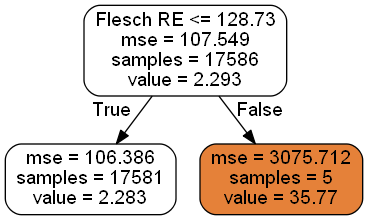

In [68]:
dectree = Read_Tree(DF)
Image(dectree.create_png()) #Displays the decision tree
#The tree suggests to split at 128. But we can see that almost all posts are in one bin, so this tree isn't very good

## Binning
Here we are trying to find the qualities that make a post have higher engagement rates than those with a lower enagement rate.

In [70]:
#Find Bin Cutoffs, we used top/bottom 10%
df_cutoffs = pd.qcut(DF['Engagement_Rate'], 10)
#Top 10 percent have engagement rate bewteen 3.736 and 1015.476
#Bottom 10 Percent have engagement rate between 0.00403 and 0.352
#This is a print statement used to find the top and bottom 10% of engagement. These numbers are manually entered below 
#The bottom 10% is found on line 0 and the top 10% is the last line(17704 in this case)

0         (0.00403, 0.352]
1           (0.352, 0.481]
2           (0.481, 0.632]
3           (0.481, 0.632]
4           (0.632, 0.807]
5           (0.352, 0.481]
6         (0.00403, 0.352]
7           (0.481, 0.632]
8         (0.00403, 0.352]
9           (0.352, 0.481]
10          (0.352, 0.481]
11        (0.00403, 0.352]
12          (0.352, 0.481]
13          (0.352, 0.481]
14          (0.352, 0.481]
15        (0.00403, 0.352]
16          (0.352, 0.481]
17          (0.352, 0.481]
18        (0.00403, 0.352]
19        (0.00403, 0.352]
20          (0.481, 0.632]
21          (0.352, 0.481]
22        (0.00403, 0.352]
23        (0.00403, 0.352]
24          (0.352, 0.481]
25          (0.807, 1.033]
26          (0.481, 0.632]
27        (0.00403, 0.352]
28          (0.352, 0.481]
29          (0.352, 0.481]
               ...        
17675    (3.736, 1015.476]
17676    (3.736, 1015.476]
17677    (3.736, 1015.476]
17678    (3.736, 1015.476]
17679    (3.736, 1015.476]
17680    (3.736, 1015.476]
1

In [71]:
#Ceiling all the color data so that the data set is completely binary
DFBins = DF.drop(['Flesch RE'], axis=1) #We don't need to raw score data, so drop the column
DFBins['Pink'] = pd.to_numeric(DFBins['Pink']).apply(np.ceil)
DFBins['Purple'] = pd.to_numeric(DFBins['Purple']).apply(np.ceil)
DFBins['Red'] = pd.to_numeric(DFBins['Red']).apply(np.ceil)
DFBins['Orange'] = pd.to_numeric(DFBins['Orange']).apply(np.ceil)
DFBins['Cyan'] = pd.to_numeric(DFBins['Cyan']).apply(np.ceil)
DFBins['Green'] = pd.to_numeric(DFBins['Green']).apply(np.ceil)
DFBins['Yellow'] = pd.to_numeric(DFBins['Yellow']).apply(np.ceil)
DFBins['Blue'] = pd.to_numeric(DFBins['Blue']).apply(np.ceil)
DFBins['Brown'] = pd.to_numeric(DFBins['Brown']).apply(np.ceil)
DFBins['White'] = pd.to_numeric(DFBins['White']).apply(np.ceil)
DFBins['Grey'] = pd.to_numeric(DFBins['Grey']).apply(np.ceil)
DFBins['Black'] = pd.to_numeric(DFBins['Black']).apply(np.ceil)

In [72]:
#Bottom Traits
DF_bot = DFBins[DFBins['Engagement_Rate'] < 0.352] #Select the posts with an engagement rate below 0.352 MANUAL DATA ENTRY
DF_bot = np.transpose(DF_bot) #Transpose the data
DF_bot['sum'] = np.sum(DF_bot,axis=1) #Take the sum over the rows (factors of a post)
DF_bot = DF_bot.sort_values(by=['sum'], ascending=False) #Sort the df by the sum so that the factors that appear the most often are at the top of the df
DF_bot.head(12) #Display the data frame to find the most common traits in the worst posts

,0,6,8,11,15,18,19,22,23,27,30,31,35,38,42,49,51,54,56,58,59,61,62,65,67,68,71,73,74,78,81,86,88,94,95,97,98,104,105,106,111,113,114,115,116,117,118,119,120,121,122,132,133,137,138,139,142,144,148,149,150,152,155,156,162,163,164,165,169,170,171,173,176,179,181,182,183,184,185,186,187,188,189,191,193,195,196,197,198,199,200,201,202,204,205,207,209,210,214,215,219,220,221,223,224,225,227,230,232,235,236,239,242,244,246,248,251,253,255,257,258,259,261,263,264,266,268,270,273,275,276,277,279,280,281,284,285,290,292,293,294,297,298,299,302,303,304,306,309,310,311,313,314,316,318,319,323,325,326,328,333,342,344,346,347,348,350,351,352,354,355,356,357,358,359,360,361,363,366,367,373,377,382,390,392,396,397,398,400,401,404,405,410,415,423,425,426,428,429,434,437,439,440,442,443,444,445,446,447,449,453,454,457,458,459,460,462,464,467,468,471,477,478,480,491,492,495,496,498,499,501,503,507,510,512,513,514,515,517,518,519,520,521,523,524,526,527,528,529,530,...,14481,14482,14490,14495,14688,14692,14696,14705,14719,14741,14742,14743,14744,14745,14746,14748,14750,14751,14752,14755,14757,14761,14765,14766,14768,14770,14772,14774,14775,14776,14779,14781,14784,14786,15058,15064,15079,15091,15103,15136,15147,15153,15199,15627,15642,15651,15654,15666,15670,15680,15681,15683,15686,15690,15692,15699,15714,15715,15721,15727,15733,15736,15739,15743,15754,15761,15762,15763,15767,15770,15776,15781,15782,15783,15788,15791,15796,15797,15802,15817,15819,15822,15826,15829,15838,15841,15842,15844,15847,15849,15850,15852,15853,15855,15856,15857,15859,15860,15861,15866,15872,15889,15891,15893,15894,15895,15896,15898,15900,15902,15904,15906,15908,15913,15915,15921,15930,15933,15935,15944,15949,15951,15953,15960,15972,15980,15982,15984,15985,15989,15990,15993,15995,15999,16007,16018,16635,16636,16638,16639,16641,16642,16644,16649,16650,16657,16848,16862,16864,16865,16866,16869,16871,16881,16883,16890,16899,16907,16910,16913,16914,16915,16916,16917,16920,16926,16928,16929,16931,16935,16940,16954,16955,16958,16968,16972,16973,16977,16983,16986,16987,16992,17007,17030,17033,17038,17051,17054,17067,17069,17071,17075,17076,17077,17079,17080,17081,17084,17085,17086,17088,17089,17090,17091,17092,17093,17094,17095,17096,17097,17098,17099,17100,17101,17102,17103,17104,17105,17107,17108,17110,17111,17114,17115,17116,17117,17118,17119,17122,17123,17124,17128,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138,17139,17140,17141,17142,17143,17144,17146,sum
Brown,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,0.00000,1.000000,0.00000,1.000000,0.000000,1.000000,1.000000,0.0000,1.000000,0.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0000,1.000000,1.000000,1.0000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.00000,0.000000,0.000000,1.00000,1.00000

Bottom 10% of posts across the industry share these 10 features (Manually Found)
1. Brown
2. Blue
3. Tree_obj
4. Building_obj
5. Middle School Reading level
6. 6pm to 10pm
7. Grey
8. Person_obj
9. High+
10. Clothing_obj

In [73]:
#Top Traits
#Same method as above
DF_top = DFBins[DFBins['Engagement_Rate'] > 3.739] #MANUAL ENTRY OF ENGAGEMENT RATE CUT OFF
DF_top = np.transpose(DF_top)
DF_top['sum'] = np.sum(DF_top,axis=1)
DF_top = DF_top.sort_values(by=['sum'], ascending=False)
DF_top.head(12)

,140,1159,1240,1262,1282,1322,1355,1363,1371,1402,1408,1695,1733,1734,1738,1758,1761,1822,1851,1862,1953,2817,3320,3333,3347,3348,3349,3353,3357,3358,3366,3370,3376,3378,3381,3384,3386,3628,3629,3635,3638,3639,3654,3655,3805,3808,3812,3813,3814,3818,3819,3820,3821,3822,3823,3826,3827,3828,3830,3831,3832,3833,3852,3884,3894,3915,3919,3936,3944,4025,4052,4072,4094,4102,4104,4109,4142,4143,4154,4166,4170,4176,4177,4181,4186,4187,4188,4192,4196,4198,4199,4202,4208,4210,4213,4215,4219,4220,4227,4229,4231,4233,4235,4236,4244,4247,4251,4252,4253,4259,4263,4264,4270,4271,4274,4276,4279,4280,4284,4289,4292,4293,4295,4296,4303,4304,4310,4314,4318,4328,4334,4338,4342,4344,4351,4356,4378,4383,4389,4408,4410,4411,4413,4426,4428,4444,4466,4470,4479,4497,4575,4576,4580,4581,4591,4608,4620,4628,4633,4637,4643,4647,4648,4666,4675,4679,4682,4696,4699,4705,4706,4707,4722,4723,4731,4735,4737,4738,4740,4752,4754,4756,4759,4761,4763,4771,4772,4777,4779,4780,4781,4782,4783,4784,4788,4790,4791,4792,4794,4797,4798,4800,4802,4803,5566,5573,5593,5867,5876,5878,5889,5895,5896,5898,5906,5911,5916,5925,5926,5928,5932,6009,6137,6152,6156,6158,6161,6171,6172,6177,6182,6197,6219,6228,6242,6246,6252,6253,6258,6259,6261,6272,6275,6282,6287,6297,6313,6314,6318,6320,...,17456,17457,17458,17459,17460,17461,17462,17463,17464,17465,17466,17467,17468,17469,17470,17471,17472,17473,17474,17475,17476,17477,17478,17479,17480,17481,17482,17483,17484,17485,17486,17487,17488,17489,17490,17491,17492,17493,17494,17495,17496,17497,17498,17499,17500,17501,17502,17503,17504,17505,17506,17507,17508,17509,17510,17511,17512,17513,17514,17515,17516,17517,17518,17519,17520,17521,17522,17523,17524,17525,17526,17527,17528,17529,17530,17531,17532,17533,17534,17535,17536,17537,17538,17539,17540,17541,17542,17543,17544,17545,17546,17547,17548,17549,17550,17551,17552,17553,17554,17555,17556,17557,17558,17559,17560,17561,17562,17563,17564,17565,17566,17567,17568,17569,17570,17571,17572,17573,17574,17575,17576,17577,17578,17579,17580,17581,17582,17583,17584,17585,17586,17587,17588,17589,17590,17591,17592,17593,17594,17595,17596,17597,17598,17599,17600,17601,17602,17603,17604,17605,17606,17607,17608,17609,17610,17611,17612,17613,17614,17615,17616,17617,17618,17619,17620,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631,17632,17633,17634,17635,17636,17637,17638,17639,17640,17641,17642,17643,17644,17645,17646,17647,17648,17649,17650,17651,17652,17653,17654,17655,17656,17657,17658,17659,17660,17661,17662,17663,17664,17665,17666,17667,17668,17669,17670,17671,17672,17673,17674,17675,17676,17677,17678,17679,17680,17681,17682,17683,17684,17685,17686,17687,17688,17689,17690,17691,17692,17693,17694,17695,17696,17697,17698,17699,17700,17701,17702,17703,17704,sum
Engagement_Rate,4.859416,4.211572,4.082796,8.043234,4.697236,4.084685,4.731225,4.302212,4.039744,4.005755,3.803334,4.06358,5.003947,4.688223,4.414687,4.520835,4.101685,5.377131,4.967684,35.473219,4.456356,5.465401,3.743367,4.058761,19.492127,4.192754,11.233301,9.513088,4.726101,5.178458,10.958003,18.428859,13.958066,28.813306,45.456041,15.586208,7.539281,7.021851,3.99378,6.964563,5.385056,5.385056,5.098617,3.920124,5.031359,7.832753,5.923345,4.571429,4.501742,4.264808,4.8223,4.041812,4.515679,5.449477,6.675958,4.222997,6.71777,5.324042,3.860627,4.055749,4.878049,3.888502,4.599303,4.557491,4.390244,6.160279,13.630662,6.59065,4.424173,4.880274,5.153934,7.297605,4.264538,4.606613,4.196123,3.941316,4.008518,5.309425,6.71613,5.412953,4.179248,5.883822,8.11784,4.530243,4.229196,8.352139,5.755775,4.382217,4.578829,3.823258,4.863076,4.035762,5.61683,6.732022,3.965382,4.074812,4.644214,4.76091,4.682356,6.762899,4.084348,4.729579,3.80555,4.335448,5.229055,3.999437,3.828253,3.902266,7.748228,5.870654,4.596991,4.443062,5.041979,4.607889,6.486371,4.380855,6.919553,4.290041,5.350745,4.120219,3.821442,4.467582,5.392066,5.067406,5.880644,4.957976,4.528881,3.967198,5.051514,4.370865,5.471528,4.512989,3.941316,4.90485,4.894406,4.096154,4.227379,4

Top 10% of posts in the industry share these 10 features
1. Brown
2. Tree_obj
3. Blue
4. Sky_tag
5. High+
6. Middle School Reading level
7. Person_obj
8. 6pm to 10pm
9. Clothing_obj
10. Grey

## Double Lasso Regression

In [91]:
#Run Lasso Regression on engagement rate to find important variables
DFlasso =  DF.drop(['Flesch RE'], axis=1) #We also don't need the raw reading score for the double lasso
#Test multiple values of alpha to find the best one
alpha = [0.0001, 0.0005, 0.001,0.003, 0.005,0.008, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,50]
#Find the infinite value and replace them with nans, then remove those rows
DFlasso = DFlasso.replace([np.inf, -np.inf],np.nan)
DFlasso = DFlasso.dropna(axis=0)
#Engagement rate has high outliers, take the log to normalize
y = np.log(DFlasso['Engagement_Rate'])
x = DFlasso.loc[:, DFlasso.columns != 'Engagement_Rate']
colnames = x.columns
#Run the lasso
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x,y)
#Print the regression information
print('The score from the regression is ' + str(reg.score(x,y)))
print('The alpha choosen from the regression is ' + str(reg.alpha_))
#Save the important variables
alpha = [reg.alpha_]
reg_coef = reg.coef_ 

The score from the regression is 0.26605876413135054
The alpha choosen from the regression is 0.005


In [84]:
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames),reverse = True))
#We see that important variables for engagement are are alilahotels_ht, bindlestifftours_ht, tours_ht, visitstockholm_ht, 
#travelinspiration_ht, explore_ht, luxurygoldvacations_ht, oberoiexperiences_ht, visitseattle_ht, 
#exploremore_ht, goexplore_ht, explorecanada_ht, luxurytravel_ht, seetheworld_ht, 6am to 12pm, 
#doctorgumbo_ht, visitnovascotia_ht, Wildlife_tag, foodtour_ht, Wilderness_tag, Event_tag, traveldeeper_ht,
#Food_tag, duvine_ht, Tree_obj, Vehicle_tag, Natural landscape_tag, Mountain_tag, Town_tag, Brown, Tree_tag,
#grandamericanadventures_ht, wanderlust_ht, Sky_tag, Water_tag, Tourism_tag, Rock_tag, 6pm to 10pm,
#NovemberPost, Mountainous landforms_tag, Building_tag, Fun_tag, and JanuaryPost 
Lasso1_col = ['alilahotels_ht', 'bindlestifftours_ht', 'tours_ht', 'visitstockholm_ht', 'travelinspiration_ht', 'explore_ht', 'luxurygoldvacations_ht', 'oberoiexperiences_ht', 'visitseattle_ht', 'exploremore_ht', 'goexplore_ht', 'explorecanada_ht', 'luxurytravel_ht', 'seetheworld_ht', '6am to 12pm', 'doctorgumbo_ht', 'visitnovascotia_ht', 'Wildlife_tag', 'foodtour_ht', 'Wilderness_tag', 'Event_tag', 'traveldeeper_ht', 'Food_tag', 'duvine_ht', 'Tree_obj', 'Vehicle_tag', 'Natural landscape_tag', 'Mountain_tag', 'Town_tag', 'Brown', 'Tree_tag', 'grandamericanadventures_ht', 'wanderlust_ht', 'Sky_tag', 'Water_tag', 'Tourism_tag', 'Rock_tag', '6pm to 10pm', 'NovemberPost', 'Mountainous landforms_tag', 'Building_tag', 'Fun_tag', 'JanuaryPost']
#THIS LIST WAS FOUND BY MANUAL ENTRY OF THE TRAITS BELOW THAT HAVE A VALUE != 0

[(0.3499, 'Cloud_tag'), (0.2939, 'Blue'), (0.2577, 'Mountain_tag'), (0.2128, 'Sea_tag'), (0.1847, 'Landmark_tag'), (0.1429, 'Night_tag'), (0.141, 'City_tag'), (0.1246, 'Tree_tag'), (0.119, 'Nature_tag'), (0.1151, 'Horizon_tag'), (0.1087, 'Water_tag'), (0.1045, 'Ocean_tag'), (0.1003, 'Vacation_tag'), (0.088, 'Landscape_tag'), (0.0866, 'Morning_tag'), (0.0846, 'Sunset_tag'), (0.0631, 'Architecture_tag'), (0.0352, 'Reflection_tag'), (0.0334, 'Natural landscape_tag'), (0.0161, 'Tree_obj'), (0.0133, 'Tourism_tag'), (0.008, 'travel_ht'), (0.0069, 'Palm tree_tag'), (0.0003, 'Tower_obj'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (-0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (-0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (-0.0, 'worldwi

In [92]:
#Now run a second lasso on all the variables found by the binning process to find what factors are important to them
#Then we will run an OLS on every factor found to determine the individual effect the select variable has on the 
#engagement rate
#Sky Tag is first
y1 = DFlasso['Sky_tag']
x1 = DFlasso.drop(['Sky_tag', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
#Run a second lasso
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
#These are all the variables that the lasso found to be related to the Sky_tag
col1 = ['Cloud_tag', 'Blue', 'Mountain_tag', 'Sea_tag', 'Landmark_tag', 'Night_tag', 'City_tag', 'Tree_tag', 'Nature_tag', 'Horizon_tag', 'Water_tag', 'Ocean_tag', 'Vacation_tag', 'Landscape_tag', 'Morning_tag', 'Sunset_tag', 'Architecture_tag', 'Reflection_tag', 'Natural landscape_tag', 'Tree_obj', 'Tourism_tag', 'travel_ht', 'Palm tree_tag', 'Tower_obj']
#THIS LIST WAS FOUND BY MANUAL ENTRY OF THE TRAITS BELOW THAT HAVE A VALUE != 0

[(0.3499, 'Cloud_tag'), (0.2939, 'Blue'), (0.2577, 'Mountain_tag'), (0.2128, 'Sea_tag'), (0.1847, 'Landmark_tag'), (0.1429, 'Night_tag'), (0.141, 'City_tag'), (0.1246, 'Tree_tag'), (0.119, 'Nature_tag'), (0.1151, 'Horizon_tag'), (0.1087, 'Water_tag'), (0.1045, 'Ocean_tag'), (0.1003, 'Vacation_tag'), (0.088, 'Landscape_tag'), (0.0866, 'Morning_tag'), (0.0846, 'Sunset_tag'), (0.0631, 'Architecture_tag'), (0.0352, 'Reflection_tag'), (0.0334, 'Natural landscape_tag'), (0.0161, 'Tree_obj'), (0.0133, 'Tourism_tag'), (0.008, 'travel_ht'), (0.0069, 'Palm tree_tag'), (0.0003, 'Tower_obj'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (-0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (-0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (-0.0, 'worldwi

In [93]:
#Run the OLS on all the identified variables for Engagmenet, plus all the identified for the independent variable (sky tag in this case)
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
#Linear regression
regs2 = LinearRegression().fit(x2, y)
reg_coef2 = regsky.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that Sky tag has a value of -0.0165 meaning that it has a small and negative impact on the engagement rate
#WE MUST PRINT THE LIST TO FIND THE TRUE EFFECT THAT A VARIABLE HAS ON ENGAGEMENT

[(2.4247, 'alilahotels_ht'), (2.1757, 'bindlestifftours_ht'), (2.0685, 'luxurygoldvacations_ht'), (1.8067, 'grandamericanadventures_ht'), (1.3905, 'tours_ht'), (1.1865, 'oberoiexperiences_ht'), (1.0854, 'travelinspiration_ht'), (1.0326, 'foodtour_ht'), (1.0275, 'exploremore_ht'), (0.9263, 'seetheworld_ht'), (0.8094, 'visitseattle_ht'), (0.7882, 'visitstockholm_ht'), (0.7122, 'goexplore_ht'), (0.6851, 'explore_ht'), (0.545, 'visitnovascotia_ht'), (0.5098, 'Wildlife_tag'), (0.4336, 'doctorgumbo_ht'), (0.4035, 'duvine_ht'), (0.365, 'luxurytravel_ht'), (0.3518, 'traveldeeper_ht'), (0.2981, 'Food_tag'), (0.2263, 'explorecanada_ht'), (0.2235, '6am to 12pm'), (0.2208, 'Sunset_tag'), (0.2105, 'Night_tag'), (0.1957, 'Vehicle_tag'), (0.193, 'Event_tag'), (0.1701, 'Town_tag'), (0.1552, 'Wilderness_tag'), (0.1279, 'Natural landscape_tag'), (0.1235, 'Tree_tag'), (0.111, 'Tree_obj'), (0.1095, 'Brown'), (0.0958, 'Rock_tag'), (0.0876, 'Mountain_tag'), (0.0853, 'Mountainous landforms_tag'), (0.0748, 'S

In [96]:
#Repeat with the other factors found, manually entering the factors with values != 0
#Brown
y1 = DFlasso['Brown']
x1 = DFlasso.drop(['Brown', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Room_tag', 'Interior design_tag', 'Building_tag']

[(0.037, 'Room_tag'), (0.0328, 'Interior design_tag'), (0.0038, 'Building_tag'), (0.0, 'À la carte food_tag'), (0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (0.0, 'yumyum_ht'), (0.0, 'yummy_ht'), (0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (0.0, 'yelptop100_ht'), (0.0, 'yelpelite_ht'), (0.0, 'yelp_ht'), (-0.0, 'yellowstone_ht'), (0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (-0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (-0.0, 'world_tag'), (0.0, 'world_ht'), (-0.0, 'woody plant_tag'), (-0.0, 'woodland_tag'), (0.0, 'wood_tag'), (0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (0.0, 'wondermore_ht'), (0.0, 'wonderfulplaces_ht'), (0.0, 'womenshistorymonth_ht'), (-0.0, 'wishlist_ht'), (-0.0, 'winterwonderland_ht'), (0.0, 'wintertravel_ht'), (0.

In [97]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that brown color has a value of 0.2073 meaning that it has a small positive effect on engagement

[(2.4535, 'alilahotels_ht'), (2.1864, 'bindlestifftours_ht'), (2.031, 'luxurygoldvacations_ht'), (1.8269, 'grandamericanadventures_ht'), (1.2989, 'tours_ht'), (1.1867, 'oberoiexperiences_ht'), (1.0732, 'travelinspiration_ht'), (1.0616, 'exploremore_ht'), (1.0361, 'foodtour_ht'), (0.8229, 'visitseattle_ht'), (0.8151, 'visitstockholm_ht'), (0.7952, 'seetheworld_ht'), (0.7288, 'goexplore_ht'), (0.6838, 'explore_ht'), (0.5871, 'visitnovascotia_ht'), (0.4667, 'Wildlife_tag'), (0.4045, 'duvine_ht'), (0.365, 'doctorgumbo_ht'), (0.343, 'traveldeeper_ht'), (0.3047, 'luxurytravel_ht'), (0.2507, 'Food_tag'), (0.2399, 'explorecanada_ht'), (0.2289, '6am to 12pm'), (0.2073, 'Brown'), (0.1941, 'Event_tag'), (0.1776, 'Vehicle_tag'), (0.1524, 'Wilderness_tag'), (0.1498, 'Town_tag'), (0.1398, 'Natural landscape_tag'), (0.1084, 'Rock_tag'), (0.1064, 'Mountain_tag'), (0.0994, 'Tree_obj'), (0.0812, 'Building_tag'), (0.0772, 'Tree_tag'), (0.067, 'Water_tag'), (0.0656, 'NovemberPost'), (0.0585, 'JanuaryPost'

In [99]:
#Tree_obj
y1 = DFlasso['Tree_obj']
x1 = DFlasso.drop(['Tree_obj', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Tree_tag', 'tree_tag', 'Natural landscape_tag', 'Plant_obj', 'Green', 'Palm tree_obj', 'House_obj', 'sky_tag', 'Real estate_tag', 'Mountain_tag', 'Nature_tag', 'Tourism_tag', 'Sky_tag', 'Swimming pool_obj', 'Town_tag', 'property_tag', 'Landmark_tag', 'resort_tag', 'Water_tag', 'House_tag', 'Coast_tag']

[(0.3171, 'Tree_tag'), (0.2944, 'tree_tag'), (0.2022, 'Natural landscape_tag'), (0.1261, 'Plant_obj'), (0.1173, 'Green'), (0.1093, 'Palm tree_obj'), (0.0797, 'House_obj'), (0.0694, 'sky_tag'), (0.0689, 'Real estate_tag'), (0.0684, 'Mountain_tag'), (0.0542, 'Nature_tag'), (0.0466, 'Tourism_tag'), (0.0356, 'Sky_tag'), (0.0335, 'Swimming pool_obj'), (0.026, 'Town_tag'), (0.0219, 'property_tag'), (0.0156, 'Landmark_tag'), (0.0058, 'resort_tag'), (0.0021, 'Water_tag'), (0.001, 'House_tag'), (0.0008, 'Coast_tag'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (-0.0,

In [100]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that tree ojects have a value of 0.1082 meaning that it has a small positive effect on engagement

[(2.4665, 'alilahotels_ht'), (2.1977, 'bindlestifftours_ht'), (2.0242, 'luxurygoldvacations_ht'), (1.8302, 'grandamericanadventures_ht'), (1.3041, 'tours_ht'), (1.1695, 'oberoiexperiences_ht'), (1.0949, 'travelinspiration_ht'), (1.0536, 'exploremore_ht'), (1.0421, 'foodtour_ht'), (0.804, 'visitstockholm_ht'), (0.7882, 'seetheworld_ht'), (0.7694, 'visitseattle_ht'), (0.7338, 'goexplore_ht'), (0.69, 'explore_ht'), (0.5988, 'visitnovascotia_ht'), (0.496, 'Wildlife_tag'), (0.4329, 'duvine_ht'), (0.3743, 'doctorgumbo_ht'), (0.3438, 'traveldeeper_ht'), (0.3138, 'luxurytravel_ht'), (0.2917, 'Food_tag'), (0.2282, 'explorecanada_ht'), (0.2261, '6am to 12pm'), (0.2066, 'resort_tag'), (0.2063, 'Town_tag'), (0.2026, 'Vehicle_tag'), (0.2017, 'Event_tag'), (0.1763, 'Brown'), (0.1578, 'sky_tag'), (0.1384, 'Wilderness_tag'), (0.1344, 'Tree_tag'), (0.1335, 'Natural landscape_tag'), (0.1105, 'Rock_tag'), (0.1082, 'Tree_obj'), (0.107, 'Mountain_tag'), (0.1023, 'Landmark_tag'), (0.0747, 'Water_tag'), (0.0

In [104]:
#Blue
y1 = DFlasso['Blue']
x1 = DFlasso.drop(['Blue', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Sky_tag', 'Vacation_tag', 'Sea_tag', 'Blue_tag', 'Blue']

[(0.0842, 'Sky_tag'), (0.0367, 'Vacation_tag'), (0.0226, 'Sea_tag'), (0.0017, 'Blue_tag'), (-0.0, 'À la carte food_tag'), (0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (-0.0, 'worldtraveler_ht'), (0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (0.0, 'world_ht'), (-0.0, 'woody plant_tag'), (-0.0, 'woodland_tag'), (-0.0, 'wood_tag'), (-0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (0.0, 'wondermore_ht'), (0.0, 'wonderfulplaces_ht'), (0.0, 'womenshistorymonth_ht'), (-0.0, 'wishlist_ht'), (0.0, 'winterwonderland_ht'), (0.0, 'wintert

In [105]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that blue colors have a value of -0.0037 meaning that it has a small negative effect on engagement

[(2.4365, 'alilahotels_ht'), (2.1984, 'bindlestifftours_ht'), (2.04, 'luxurygoldvacations_ht'), (1.8301, 'grandamericanadventures_ht'), (1.3003, 'tours_ht'), (1.1695, 'oberoiexperiences_ht'), (1.0782, 'travelinspiration_ht'), (1.0575, 'exploremore_ht'), (1.0421, 'foodtour_ht'), (0.8359, 'visitseattle_ht'), (0.8155, 'visitstockholm_ht'), (0.8009, 'seetheworld_ht'), (0.7335, 'goexplore_ht'), (0.6831, 'explore_ht'), (0.5866, 'visitnovascotia_ht'), (0.4888, 'Wildlife_tag'), (0.4155, 'duvine_ht'), (0.3735, 'doctorgumbo_ht'), (0.3463, 'traveldeeper_ht'), (0.2997, 'luxurytravel_ht'), (0.2862, 'Food_tag'), (0.2362, 'explorecanada_ht'), (0.2324, '6am to 12pm'), (0.1933, 'Event_tag'), (0.1885, 'Vehicle_tag'), (0.1843, 'Town_tag'), (0.1543, 'Wilderness_tag'), (0.13, 'Natural landscape_tag'), (0.1255, 'Brown'), (0.1155, 'Rock_tag'), (0.114, 'Tree_obj'), (0.094, 'Mountain_tag'), (0.0922, 'Tree_tag'), (0.0851, 'Tourism_tag'), (0.0843, 'Fun_tag'), (0.0671, 'Water_tag'), (0.0661, 'NovemberPost'), (0.0

In [107]:
#High School and college reading level
y1 = DFlasso['High+']
x1 = DFlasso.drop(['High+', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['High+']

[(0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (0.0, 'yellow_tag'), (0.0, 'yard_tag'), (0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (-0.0, 'worldtravel_ht'), (0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (-0.0, 'world_tag'), (-0.0, 'world_ht'), (-0.0, 'woody plant_tag'), (-0.0, 'woodland_tag'), (0.0, 'wood_tag'), (0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (0.0, 'wondermore_ht'), (0.0, 'wonderfulplaces_ht'), (0.0, 'womenshistorymonth_ht'), (-0.0, 'wishlist_ht'), (0.0, 'winterwonderland_ht'), (-0.0, 'wintertravel_ht'), (-0.0, 'wintergetaway_ht'), (0.0, 'winterbreak_ht'), (-0.0, 'winter_tag'), (-0.0, 

In [108]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that High+ (High school and college reading levels) have a value of 0.021 meaning that it has a small positive effect on engagement

[(2.4252, 'alilahotels_ht'), (2.1941, 'bindlestifftours_ht'), (2.0425, 'luxurygoldvacations_ht'), (1.8338, 'grandamericanadventures_ht'), (1.3014, 'tours_ht'), (1.1621, 'oberoiexperiences_ht'), (1.0718, 'travelinspiration_ht'), (1.0631, 'exploremore_ht'), (1.0453, 'foodtour_ht'), (0.8383, 'visitseattle_ht'), (0.8234, 'visitstockholm_ht'), (0.8083, 'seetheworld_ht'), (0.7348, 'goexplore_ht'), (0.6856, 'explore_ht'), (0.592, 'visitnovascotia_ht'), (0.4893, 'Wildlife_tag'), (0.4149, 'duvine_ht'), (0.3785, 'doctorgumbo_ht'), (0.353, 'traveldeeper_ht'), (0.3023, 'luxurytravel_ht'), (0.2838, 'Food_tag'), (0.2385, 'explorecanada_ht'), (0.2318, '6am to 12pm'), (0.2022, 'Event_tag'), (0.1877, 'Town_tag'), (0.1874, 'Vehicle_tag'), (0.1534, 'Wilderness_tag'), (0.1395, 'Natural landscape_tag'), (0.1357, 'Brown'), (0.1216, 'Rock_tag'), (0.1134, 'Tree_obj'), (0.0986, 'Mountain_tag'), (0.0805, 'Tree_tag'), (0.0682, 'Water_tag'), (0.0663, 'NovemberPost'), (0.0573, 'Tourism_tag'), (0.0569, 'Mountainous

In [111]:
#Middle School Reading level
y1 = DFlasso['Middle School']
x1 = DFlasso.drop(['Middle School', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Middle School']

[(-0.0, 'À la carte food_tag'), (0.0, 'zomato_ht'), (0.0, 'zionnationalpark_ht'), (0.0, 'yumyum_ht'), (0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (0.0, 'yelptop100_ht'), (0.0, 'yelpelite_ht'), (0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (0.0, 'yellow_tag'), (0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (-0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (-0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (-0.0, 'world_ht'), (-0.0, 'woody plant_tag'), (-0.0, 'woodland_tag'), (-0.0, 'wood_tag'), (-0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (-0.0, 'wondermore_ht'), (0.0, 'wonderfulplaces_ht'), (-0.0, 'womenshistorymonth_ht'), (0.0, 'wishlist_ht'), (0.0, 'winterwonderland_ht'), (-0.0, 'wintertravel_ht'), (0.0, 'wintergetaway_ht'), (-0.0, 'winterbreak_ht'), (-0.0, 'winter_tag'), (0.

In [112]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that Middle school reading level have a value of 0.0299 meaning that it has a small positive effect on engagement

[(2.4361, 'alilahotels_ht'), (2.1943, 'bindlestifftours_ht'), (2.0478, 'luxurygoldvacations_ht'), (1.8306, 'grandamericanadventures_ht'), (1.3044, 'tours_ht'), (1.1733, 'oberoiexperiences_ht'), (1.0706, 'travelinspiration_ht'), (1.0565, 'exploremore_ht'), (1.0433, 'foodtour_ht'), (0.8373, 'visitseattle_ht'), (0.8284, 'visitstockholm_ht'), (0.8089, 'seetheworld_ht'), (0.7315, 'goexplore_ht'), (0.6879, 'explore_ht'), (0.6031, 'visitnovascotia_ht'), (0.4928, 'Wildlife_tag'), (0.417, 'duvine_ht'), (0.3687, 'doctorgumbo_ht'), (0.3503, 'traveldeeper_ht'), (0.3029, 'luxurytravel_ht'), (0.2835, 'Food_tag'), (0.232, '6am to 12pm'), (0.2265, 'explorecanada_ht'), (0.2042, 'Event_tag'), (0.1885, 'Town_tag'), (0.1883, 'Vehicle_tag'), (0.1524, 'Wilderness_tag'), (0.1412, 'Natural landscape_tag'), (0.1356, 'Brown'), (0.1215, 'Rock_tag'), (0.1136, 'Tree_obj'), (0.0955, 'Mountain_tag'), (0.0803, 'Tree_tag'), (0.0668, 'Water_tag'), (0.0664, 'NovemberPost'), (0.0606, 'Mountainous landforms_tag'), (0.0589

In [114]:
#Person_obj
y1 = DFlasso['Person_obj']
x1 = DFlasso.drop(['Person_obj', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Clothing_obj', 'Recreation_tag', 'Man_obj', 'Footwear_obj', 'Bicycle_obj', 'Tourism_tag', 'visitstockholm_ht', 'Vehicle_tag', 'Wheel_obj', 'Water_tag', 'Person_obj']

[(0.3026, 'Clothing_obj'), (0.1711, 'Recreation_tag'), (0.1195, 'Man_obj'), (0.0874, 'Footwear_obj'), (0.0521, 'Bicycle_obj'), (0.0145, 'Tourism_tag'), (0.013, 'visitstockholm_ht'), (0.0124, 'Vehicle_tag'), (0.012, 'Wheel_obj'), (0.0009, 'Water_tag'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (-0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (-0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (-0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (0.0, 'worldtravel_ht'), (0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (-0.0, 'world_ht'), (0.0, 'woody plant_tag'), (0.0, 'woodland_tag'), (-0.0, 'wood_tag'), (0.0, 'wood flooring_tag'), (-0.0, 'wondersofthewo

In [115]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that Person_obj have a value of 0.0077 meaning that it has a small positive effect on engagement

[(2.4295, 'alilahotels_ht'), (2.1942, 'bindlestifftours_ht'), (2.0568, 'luxurygoldvacations_ht'), (1.8254, 'grandamericanadventures_ht'), (1.3061, 'tours_ht'), (1.1581, 'oberoiexperiences_ht'), (1.0663, 'travelinspiration_ht'), (1.062, 'exploremore_ht'), (1.0597, 'foodtour_ht'), (0.8319, 'visitstockholm_ht'), (0.821, 'visitseattle_ht'), (0.8029, 'seetheworld_ht'), (0.7469, 'goexplore_ht'), (0.6881, 'explore_ht'), (0.5767, 'visitnovascotia_ht'), (0.4698, 'Wildlife_tag'), (0.4271, 'duvine_ht'), (0.3865, 'doctorgumbo_ht'), (0.3477, 'traveldeeper_ht'), (0.3039, 'luxurytravel_ht'), (0.2686, 'Food_tag'), (0.2514, 'explorecanada_ht'), (0.2418, 'Event_tag'), (0.2332, '6am to 12pm'), (0.1807, 'Town_tag'), (0.1738, 'Vehicle_tag'), (0.1702, 'Wilderness_tag'), (0.1493, 'Brown'), (0.1256, 'Natural landscape_tag'), (0.1249, 'Rock_tag'), (0.1058, 'Tree_obj'), (0.1049, 'Mountain_tag'), (0.0894, 'Fun_tag'), (0.0834, 'Tourism_tag'), (0.0831, 'Tree_tag'), (0.0804, 'Wheel_obj'), (0.0658, 'NovemberPost'), 

In [117]:
#Person_obj
y1 = DFlasso['6pm to 10pm']
x1 = DFlasso.drop(['6pm to 10pm', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['beintrepid_ht', 'Sky_tag']

[(0.0415, 'beintrepid_ht'), (0.0033, 'Sky_tag'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (-0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (0.0, 'yum_ht'), (0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (0.0, 'yelptop100_ht'), (0.0, 'yelpelite_ht'), (0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (0.0, 'worldtraveler_ht'), (0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (-0.0, 'world_ht'), (0.0, 'woody plant_tag'), (-0.0, 'woodland_tag'), (-0.0, 'wood_tag'), (0.0, 'wood flooring_tag'), (-0.0, 'wondersoftheworld_ht'), (0.0, 'wondermore_ht'), (-0.0, 'wonderfulplaces_ht'), (0.0, 'womenshistorymonth_ht'), (0.0, 'wishlist_ht'), (-0.0, 'winterwonderland_ht'), (0.0, 'wintertravel_ht'), (0.0, 'wintergetaway_ht'), (-0.0

In [118]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that posting between 6pm and 10pm have a value of 0.0632 meaning that it has a small positive effect on engagement

[(2.4247, 'alilahotels_ht'), (2.1862, 'bindlestifftours_ht'), (2.0399, 'luxurygoldvacations_ht'), (1.827, 'grandamericanadventures_ht'), (1.3014, 'tours_ht'), (1.1648, 'oberoiexperiences_ht'), (1.0668, 'travelinspiration_ht'), (1.0578, 'exploremore_ht'), (1.04, 'foodtour_ht'), (0.8365, 'visitseattle_ht'), (0.8187, 'visitstockholm_ht'), (0.7992, 'seetheworld_ht'), (0.7244, 'goexplore_ht'), (0.6842, 'explore_ht'), (0.5968, 'visitnovascotia_ht'), (0.5016, 'Wildlife_tag'), (0.4098, 'duvine_ht'), (0.3703, 'doctorgumbo_ht'), (0.3478, 'traveldeeper_ht'), (0.2953, 'luxurytravel_ht'), (0.284, 'Food_tag'), (0.2322, '6am to 12pm'), (0.227, 'explorecanada_ht'), (0.2034, 'Event_tag'), (0.1925, 'Vehicle_tag'), (0.1881, 'Town_tag'), (0.1587, 'Wilderness_tag'), (0.1413, 'Natural landscape_tag'), (0.137, 'Brown'), (0.1278, 'Rock_tag'), (0.1135, 'Tree_obj'), (0.0946, 'Mountain_tag'), (0.0796, 'Tree_tag'), (0.0696, 'Water_tag'), (0.068, 'NovemberPost'), (0.0665, 'Mountainous landforms_tag'), (0.0662, 'To

In [122]:
#Clothing_obj
y1 = DFlasso['Clothing_obj']
x1 = DFlasso.drop(['Clothing_obj', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Woman_obj', 'Man_obj', 'Person_obj', 'Human face_obj', 'Footwear_obj', 'Clothing_obj']

[(0.412, 'Woman_obj'), (0.3019, 'Man_obj'), (0.1733, 'Person_obj'), (0.1442, 'Human face_obj'), (0.0296, 'Footwear_obj'), (0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (-0.0, 'zionnationalpark_ht'), (0.0, 'yumyum_ht'), (0.0, 'yummy_ht'), (0.0, 'yum_ht'), (0.0, 'yosemitenationalpark_ht'), (0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (-0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (0.0, 'worldwildlifeday_ht'), (0.0, 'worldtravelpics_ht'), (-0.0, 'worldtraveler_ht'), (-0.0, 'worldtravel_ht'), (0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (0.0, 'world_ht'), (-0.0, 'woody plant_tag'), (0.0, 'woodland_tag'), (0.0, 'wood_tag'), (-0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (0.0, 'wondermore_ht'), (-0.0, 'wonderfulplaces_ht'), (0.0, 'womenshistorymonth_ht'), (0.0, 'wishlist_ht'), (-0.0, 'winterwonder

In [123]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that Clothing_obj have a value of -0.0563 meaning that it has a small negative effect on engagement

[(2.4397, 'alilahotels_ht'), (2.1926, 'bindlestifftours_ht'), (2.0594, 'luxurygoldvacations_ht'), (1.822, 'grandamericanadventures_ht'), (1.3044, 'tours_ht'), (1.1595, 'oberoiexperiences_ht'), (1.0637, 'travelinspiration_ht'), (1.0637, 'foodtour_ht'), (1.06, 'exploremore_ht'), (0.8327, 'visitstockholm_ht'), (0.8191, 'visitseattle_ht'), (0.7969, 'seetheworld_ht'), (0.749, 'goexplore_ht'), (0.6839, 'explore_ht'), (0.5633, 'visitnovascotia_ht'), (0.4676, 'Wildlife_tag'), (0.4197, 'duvine_ht'), (0.4044, 'doctorgumbo_ht'), (0.3458, 'traveldeeper_ht'), (0.3044, 'luxurytravel_ht'), (0.2608, 'Food_tag'), (0.2599, 'explorecanada_ht'), (0.2581, 'Event_tag'), (0.2335, '6am to 12pm'), (0.1864, 'Vehicle_tag'), (0.1827, 'Town_tag'), (0.1688, 'Wilderness_tag'), (0.1532, 'Brown'), (0.1243, 'Rock_tag'), (0.1236, 'Natural landscape_tag'), (0.1077, 'Fun_tag'), (0.1061, 'Mountain_tag'), (0.1051, 'Tree_obj'), (0.0905, 'Tourism_tag'), (0.084, 'Tree_tag'), (0.0654, 'NovemberPost'), (0.0599, 'Water_tag'), (0.

In [125]:
#Grey
y1 = DFlasso['Grey']
x1 = DFlasso.drop(['Grey', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Grey']

[(-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (-0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (0.0, 'yellowstone_ht'), (-0.0, 'yellow_tag'), (0.0, 'yard_tag'), (0.0, 'yacht_tag'), (0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (-0.0, 'worldtravelpics_ht'), (-0.0, 'worldtraveler_ht'), (-0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht'), (0.0, 'world_tag'), (-0.0, 'world_ht'), (0.0, 'woody plant_tag'), (0.0, 'woodland_tag'), (0.0, 'wood_tag'), (0.0, 'wood flooring_tag'), (0.0, 'wondersoftheworld_ht'), (-0.0, 'wondermore_ht'), (-0.0, 'wonderfulplaces_ht'), (-0.0, 'womenshistorymonth_ht'), (-0.0, 'wishlist_ht'), (0.0, 'winterwonderland_ht'), (0.0, 'wintertravel_ht'), (-0.0, 'wintergetaway_ht'), (-0.0, 'winterbreak_ht'), (0.0, 'winter_tag')

In [126]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that having a grey picture has a value of 0.12 meaning that it has a positive effect on engagement

[(2.4255, 'alilahotels_ht'), (2.1962, 'bindlestifftours_ht'), (2.0442, 'luxurygoldvacations_ht'), (1.8299, 'grandamericanadventures_ht'), (1.302, 'tours_ht'), (1.1704, 'oberoiexperiences_ht'), (1.0713, 'travelinspiration_ht'), (1.0645, 'exploremore_ht'), (1.0453, 'foodtour_ht'), (0.8358, 'visitseattle_ht'), (0.8187, 'visitstockholm_ht'), (0.8016, 'seetheworld_ht'), (0.7389, 'goexplore_ht'), (0.6867, 'explore_ht'), (0.5965, 'visitnovascotia_ht'), (0.4899, 'Wildlife_tag'), (0.4197, 'duvine_ht'), (0.3787, 'doctorgumbo_ht'), (0.3494, 'traveldeeper_ht'), (0.3024, 'luxurytravel_ht'), (0.2896, 'Food_tag'), (0.2339, 'explorecanada_ht'), (0.2328, '6am to 12pm'), (0.2061, 'Event_tag'), (0.1922, 'Town_tag'), (0.1891, 'Vehicle_tag'), (0.1549, 'Wilderness_tag'), (0.1528, 'Brown'), (0.1441, 'Natural landscape_tag'), (0.1214, 'Rock_tag'), (0.12, 'Grey'), (0.1136, 'Tree_obj'), (0.0939, 'Mountain_tag'), (0.0829, 'Tree_tag'), (0.0665, 'NovemberPost'), (0.0661, 'Water_tag'), (0.06, 'Mountainous landforms

In [128]:
#Building_obj
y1 = DFlasso['Building_obj']
x1 = DFlasso.drop(['Building_obj', 'Engagement_Rate'], axis=1)
colnames1 = x1.columns
reg=LassoCV(alphas=alpha, cv=3, max_iter=1000, tol=0.0001).fit(x1,y1)
reg_coef = reg.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef), colnames1),reverse = True))
col1 = ['Building_tag', 'building_tag', 'interior design_tag', 'Town_tag', 'Architecture_tag', 'city_tag', 'House_obj', 'Landmark_tag', 'Window_obj', 'City_tag', 'Interior design_tag', 'Chair_obj', 'Skyscraper_obj', 'Tourism_tag', 'Tower_obj', 'Table_obj', 'Building_obj']

[(0.2811, 'Building_tag'), (0.2701, 'building_tag'), (0.2126, 'interior design_tag'), (0.2108, 'Town_tag'), (0.1825, 'Architecture_tag'), (0.1713, 'city_tag'), (0.1282, 'House_obj'), (0.1201, 'Landmark_tag'), (0.1127, 'Window_obj'), (0.1046, 'City_tag'), (0.0882, 'Interior design_tag'), (0.0788, 'Chair_obj'), (0.0373, 'Skyscraper_obj'), (0.0203, 'Tourism_tag'), (0.0139, 'Tower_obj'), (0.0047, 'Table_obj'), (-0.0, 'À la carte food_tag'), (-0.0, 'zomato_ht'), (-0.0, 'zionnationalpark_ht'), (-0.0, 'yumyum_ht'), (-0.0, 'yummy_ht'), (-0.0, 'yum_ht'), (-0.0, 'yosemitenationalpark_ht'), (-0.0, 'yosemite_ht'), (-0.0, 'yelptop100_ht'), (-0.0, 'yelpelite_ht'), (-0.0, 'yelp_ht'), (-0.0, 'yellowstone_ht'), (0.0, 'yellow_tag'), (-0.0, 'yard_tag'), (0.0, 'yacht_tag'), (-0.0, 'wyoming_ht'), (-0.0, 'wymtm_ht'), (-0.0, 'worldwildlifeday_ht'), (0.0, 'worldtravelpics_ht'), (-0.0, 'worldtraveler_ht'), (-0.0, 'worldtravel_ht'), (-0.0, 'worldnomads_ht'), (-0.0, 'worldexpeditions_ht'), (-0.0, 'worlderlust_ht

In [129]:
cols = set(Lasso1_col+col1)
cols = list(cols)
x2 = DFlasso[cols]
colnames2 = x2.columns
reg2 = LinearRegression().fit(x2, y)
reg_coef2 = reg2.coef_ 
print(sorted(zip(map(lambda x: round(x,4), reg_coef2), colnames2),reverse = True))
#From this list we can see that Building_obj have a value of 0.0153 meaning that it has a small positive effect on engagement

[(2.4539, 'alilahotels_ht'), (2.1845, 'bindlestifftours_ht'), (2.019, 'luxurygoldvacations_ht'), (1.8265, 'grandamericanadventures_ht'), (1.2893, 'tours_ht'), (1.1778, 'oberoiexperiences_ht'), (1.0821, 'travelinspiration_ht'), (1.0625, 'exploremore_ht'), (1.0301, 'foodtour_ht'), (0.807, 'visitstockholm_ht'), (0.7948, 'seetheworld_ht'), (0.7691, 'visitseattle_ht'), (0.7269, 'goexplore_ht'), (0.6833, 'explore_ht'), (0.5969, 'visitnovascotia_ht'), (0.4665, 'Wildlife_tag'), (0.4262, 'duvine_ht'), (0.3728, 'doctorgumbo_ht'), (0.3273, 'traveldeeper_ht'), (0.3045, 'luxurytravel_ht'), (0.246, 'Food_tag'), (0.2388, 'explorecanada_ht'), (0.2306, '6am to 12pm'), (0.2178, 'Brown'), (0.2168, 'city_tag'), (0.1955, 'Event_tag'), (0.1812, 'Vehicle_tag'), (0.1624, 'Town_tag'), (0.1518, 'Wilderness_tag'), (0.1467, 'Natural landscape_tag'), (0.1153, 'Mountain_tag'), (0.1047, 'Rock_tag'), (0.0991, 'Tree_obj'), (0.0859, 'Tree_tag'), (0.0704, 'NovemberPost'), (0.0696, 'Water_tag'), (0.0683, 'Landmark_tag'),